In [94]:
#Packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, glob

from sklearn import preprocessing


## Load and Manipulate Data

### Load the data

### Franklin's work starts below

In [95]:
#Load the census data
census_dat = pd.read_csv('./data/Census_Data_Cleaned.csv', dtype = 'str')

#Load the hospital beds data
beds_dat = pd.read_csv('./data/hospital_beds_data.csv', dtype = 'str')

#Load the cases data
cases_nyc = pd.read_csv('./zcta-history/2020-04-01.csv', dtype = 'str')

cases_nyc_0407 = pd.read_csv('./zcta-history/2020-04-07.csv', dtype = 'str')
cases_nyc_0414 = pd.read_csv('./zcta-history/2020-04-14.csv', dtype = 'str')
cases_nyc_0421 = pd.read_csv('./zcta-history/2020-04-21.csv', dtype = 'str')
cases_nyc_0428 = pd.read_csv('./zcta-history/2020-04-28.csv', dtype = 'str')

In [96]:
cases_nyc = cases_nyc.rename(columns={"Positive": "Positive_0401", "Total": "Total_0401", 
                                      "zcta_cum.perc_pos":"zcta_cum_perc_pos_0401"})

cases_nyc_0407 = cases_nyc_0407.rename(columns={"Positive": "Positive_0407", "Total": "Total_0407", 
                                      "zcta_cum.perc_pos":"zcta_cum_perc_pos_0407"})

# cases_nyc_0414 = cases_nyc_0414.rename(columns={"Positive": "Positive_0414", "Total": "Total_0414", 
#                                      "zcta_cum.perc_pos":"zcta_cum_perc_pos_0414"})

# cases_nyc_0421 = cases_nyc_0421.rename(columns={"Positive": "Positive_0421", "Total": "Total_0421", 
#                                      "zcta_cum.perc_pos":"zcta_cum_perc_pos_0421"})

# cases_nyc_0428 = cases_nyc_0428.rename(columns={"Positive": "Positive_0428", "Total": "Total_0428", 
#                                      "zcta_cum.perc_pos":"zcta_cum_perc_pos_0428"})

In [97]:
#Join together all the weekly cases data
cases_nyc = cases_nyc.merge(cases_nyc_0407, how = 'left', left_on = 'MODZCTA', right_on = 'MODZCTA')
# cases_nyc = cases_nyc.merge(cases_nyc_0414, how = 'left', left_on = 'MODZCTA', right_on = 'MODZCTA')
# cases_nyc = cases_nyc.merge(cases_nyc_0421, how = 'left', left_on = 'MODZCTA', right_on = 'MODZCTA')
# cases_nyc = cases_nyc.merge(cases_nyc_0428, how = 'left', left_on = 'MODZCTA', right_on = 'MODZCTA')

In [98]:
#Join all the values together
data = cases_nyc.merge(census_dat, how = 'left', left_on = 'MODZCTA', right_on = 'zip_code_tabulation_area')
data = data.merge(beds_dat, how = 'left', left_on = 'MODZCTA', right_on = 'zip')

data["beds"] = data["beds"].fillna(0)

In [99]:
#Remove the first record (no zip)
data = data[1:]

#Remove the zip code columns
data = data.loc[:, data.columns != 'zip_code_tabulation_area']
data = data.loc[:, data.columns != 'zip']

In [100]:
#Cast the rest of the columns as float
for col in data.columns:
    if col == "MODZCTA":
        continue 
    else:
        data.loc[:,col] = data.loc[:,col].astype(float)
        
#Divide by 100 for percents
# data.loc[:,"zcta_cum_perc_pos_0401"] = data.loc[:,"zcta_cum_perc_pos_0401"]/100.0
data.loc[:,"zcta_cum_perc_pos_0407"] = data.loc[:,"zcta_cum_perc_pos_0407"]/100.0
# data.loc[:,"zcta_cum_perc_pos_0414"] = data.loc[:,"zcta_cum_perc_pos_0414"]/100.0
# data.loc[:,"zcta_cum_perc_pos_0421"] = data.loc[:,"zcta_cum_perc_pos_0421"]/100.0
# data.loc[:,"zcta_cum_perc_pos_0428"] = data.loc[:,"zcta_cum_perc_pos_0428"]/100.0


In [101]:
#Exclude columns with > 10 nulls
data = data.drop(['med_value','avg_hoursworked','med_contractrent',
                  'avg_income_deficit_pastyear','med_age_marriage'], axis = 1)

In [102]:
#Impute values for columsn with < 10 nulls
#data["beds"] = data["beds"].fillna(0)
for col in data.columns:
    data[col] = data[col].fillna(data[col].mean())

In [103]:
#Check we've removed them all:
data.isnull().sum(axis = 0).sort_values().tail() #0. good.

perc_transport_to_work_walk      0
perc_transport_to_work_bike      0
perc_transport_to_work_public    0
perc_leave_for_work_530to559     0
beds                             0
dtype: int64

In [104]:
#Percent Columns
cols = [col for col in data.columns if 'perc' in col]

for col in cols:
    data.loc[data[col] > 1, col] = 1

In [105]:
#Number of cases per capita - continuous
cases_per_10k = data[["MODZCTA", "Positive_0407", 'pop_total']]

cases_per_10k.loc[:,"cases_per_10k_0407"] = 10000 * cases_per_10k.loc[:,"Positive_0407"] / \
    cases_per_10k.loc[:,"pop_total"]

y_categorical_0407 = np.zeros(len(cases_per_10k.cases_per_10k_0407))
y_categorical_0407 = y_categorical_0407.astype(str)

#Low
y_categorical_0407[cases_per_10k.cases_per_10k_0407 <= 75] = "Low"
#High
y_categorical_0407[cases_per_10k.cases_per_10k_0407 > 75] = "High"

pd.DataFrame(y_categorical_0407, columns = ['y']).groupby('y').size()

y
High    99
Low     78
dtype: int64

In [106]:
data = data.merge(cases_per_10k, how = 'left', left_on = 'MODZCTA', right_on = 'MODZCTA')

In [108]:
data

,MODZCTA,Positive_0401,Total_0401,Positive_0407_x,Total_0407,zcta_cum_perc_pos_0407,median_house_income,housing_units,pop_total_x,med_age,...,perc_finance,perc_scientific,perc_education_healthcare,perc_arts_entertainment,perc_otherservices,perc_publicadministration,beds,Positive_0407_y,pop_total_y,cases_per_10k_0407
0,10001,113.0,265.0,170.0,364.0,0.4670,86801.0,13305.0,23537.0,35.6,...,0.020243,0.037787,0.191633,0.017544,0.018893,0.045884,0.0,170.0,23537.0,72.226707
1,10002,250.0,542.0,405.0,792.0,0.5114,33726.0,35691.0,80736.0,40.8,...,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.0,405.0,80736.0,50.163496
2,10003,161.0,379.0,230.0,543.0,0.4236,98151.0,31575.0,57112.0,32.1,...,0.040080,0.088176,0.126253,0.036072,0.026052,0.052104,501.0,230.0,57112.0,40.271747
3,10004,16.0,38.0,20.0,45.0,0.4444,119691.0,2082.0,3221.0,33.1,...,0.000000,0.312500,0.000000,0.000000,0.000000,0.000000,0.0,20.0,3221.0,62.092518
4,10005,25.0,81.0,32.0,103.0,0.3107,124194.0,5254.0,8131.0,29.4,...,0.032997,0.035747,0.156737,0.096242,0.039413,0.048579,0.0,32.0,8131.0,39.355553
5,10006,6.0,24.0,8.0,33.0,0.2424,123691.0,2155.0,3110.0,31.4,...,0.034156,0.018975,0.157495,0.028463,0.064516,0.053131,0.0,8.0,3110.0,25.723473
6,10007,26.0,67.0,30.0,86.0,0.3488,250001.0,3178.0,6876.0,35.4,...,0.058323,0.050040,0.296906,0.033130,0.038192,0.047279,0.0,30.0,6876.0,43.630017
7,10009,181.0,450.0,298.0,662.0,0.4502,59090.0,31531.0,60865.0,37.0,...,0.028249,0.033898,0.206215,0.036723,0.005650,0.019774,0.0,298.0,60865.0,48.960815
8,10010,101.0,282.0,133.0,377.0,0.3528,101718.0,18044.0,31447.0,34.6,...,0.043269,0.072115,0.216346,0.048077,0.067308,0.033654,0.0,133.0,31447.0,42.293383
9,10011,222.0,487.0,308.0,640.0,0.4812,109818.0,34012.0,52349.0,39.5,...,0.028902,0.031792,0.196532,0.026012,0.017341,0.072254,0.0,308.0,52349.0,58.835890


In [109]:
hi_data = data[data['cases_per_10k_0407'] > 75]
low_data = data[data['cases_per_10k_0407'] <= 75]

In [111]:
print(hi_data.shape) # 80 training
print(low_data.shape) # 62 training
hi_data.head()

(99, 87)
(78, 87)


,MODZCTA,Positive_0401,Total_0401,Positive_0407_x,Total_0407,zcta_cum_perc_pos_0407,median_house_income,housing_units,pop_total_x,med_age,...,perc_finance,perc_scientific,perc_education_healthcare,perc_arts_entertainment,perc_otherservices,perc_publicadministration,beds,Positive_0407_y,pop_total_y,cases_per_10k_0407
15,10018,66.0,151.0,116.0,251.0,0.4622,105500.0,5546.0,9168.0,30.7,...,0.031447,0.035639,0.148847,0.023061,0.027254,0.064990,0.0,116.0,9168.0,126.527051
28,10032,308.0,548.0,508.0,857.0,0.5928,37280.0,21691.0,62685.0,34.2,...,0.022945,0.072658,0.143403,0.061185,0.034417,0.030593,0.0,508.0,62685.0,81.040121
31,10035,147.0,345.0,301.0,580.0,0.5190,27424.0,14452.0,33920.0,35.2,...,0.059002,0.033283,0.130106,0.025719,0.063540,0.024206,0.0,301.0,33920.0,88.738208
33,10037,109.0,204.0,146.0,282.0,0.5177,35491.0,9856.0,18777.0,36.1,...,0.053876,0.066520,0.167675,0.019791,0.035184,0.032985,229.0,146.0,18777.0,77.754700
40,10075,160.0,371.0,226.0,488.0,0.4631,111691.0,16688.0,25756.0,44.1,...,0.044096,0.020927,0.159193,0.029148,0.032885,0.074738,422.0,226.0,25756.0,87.746544


In [114]:
DROP_COLUMNS = ['Positive_0401', 'Total_0401', 'Positive_0407_x', 'Total_0407', 'zcta_cum_perc_pos_0407', 'cases_per_10k_0407', 'Positive_0407_y', 'pop_total_y', 'pop_total_x']

train_data = hi_data[:80]
train_y = train_data['cases_per_10k_0407']
train_data = train_data.drop(DROP_COLUMNS, axis=1)

test_data = hi_data[80:]
test_y = test_data['cases_per_10k_0407']
test_data = test_data.drop(DROP_COLUMNS, axis=1)

scale_data = hi_data
scale_data = scale_data.drop(DROP_COLUMNS, axis=1)

In [29]:
# #Exclude outcome variables
# X = data.loc[:,"median_house_income":]
# #Exclude a few covariates we decided against
# X = X.drop(['perc_leave_for_work_12ato459',
#        'perc_leave_for_work_5to529', 'perc_leave_for_work_530to559',
#        'perc_leave_for_work_6to629', 'perc_leave_for_work_630to659',
#        'perc_leave_for_work_7to729', 'perc_leave_for_work_730to759',
#        'perc_leave_for_work_8to829', 'perc_leave_for_work_830to859',
#        'perc_leave_for_work_9to959', 'perc_leave_for_work_10to1059',
#        'perc_leave_for_work_11to1159', 'perc_leave_for_work_12pto359',
#        'perc_leave_for_work_4pto1159'], axis = 1)

# #Set the scaler
# X = preprocessing.StandardScaler().fit_transform(X)

## Normalize

In [115]:
#Set the scaler
scaler = preprocessing.StandardScaler().fit(scale_data)
#Scale train/test data
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

## Plot regularization path

In [116]:

from sklearn import linear_model
import itertools

eps = 0.0001
alphas_lasso, coefs_lasso, _ = linear_model.enet_path(
    train_data, train_y,n_alphas=10000, eps=eps, l1_ratio=1., fit_intercept=False)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89.6760381400818, tolerance: 88.91931829690479
  tol, rng, random, positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89.57544427190442, tolerance: 88.91931829690479
  tol, rng, random, positive)


In [124]:
cols = hi_data
data_columns = cols.drop(DROP_COLUMNS, axis=1).columns

/usr/local/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


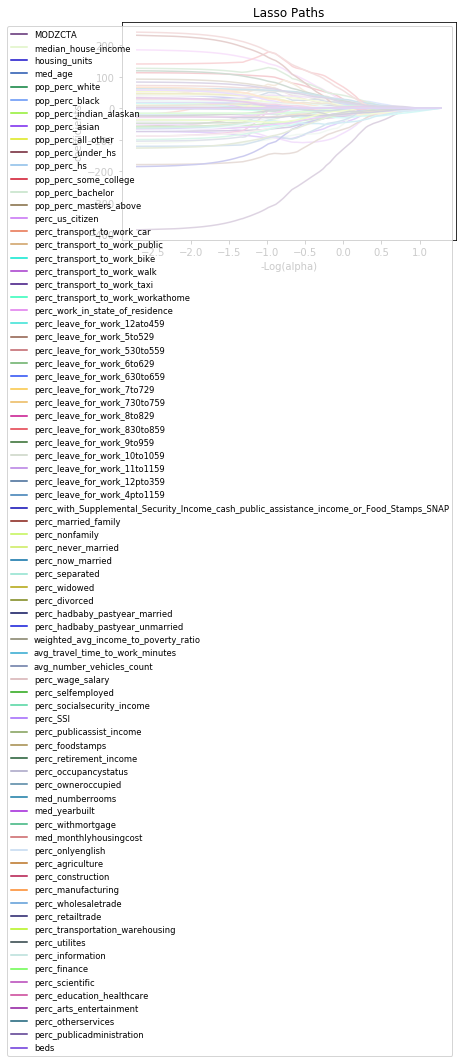

In [125]:
# Plot the regularization paths:
# Display results

# make legend small ==
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('small')
# make legend small ==

plt.figure(1)
colors = itertools.cycle(['b', 'r', 'g', 'c', 'k'])
neg_log_alphas_lasso = np.log10(alphas_lasso)
i = 0
for coef_l, c in zip(coefs_lasso, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=np.random.rand(3,), label=data_columns[i])
    i += 1

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso Paths')
plt.axis('tight')
plt.legend(prop=fontP)
plt.show()

### gridsearch to find optimal alpha

In [138]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

lasso = Lasso(random_state=0, max_iter=1000)
alphas = np.logspace(-1.5, 3, 30)

tuned_parameters = [{'alpha': alphas}]
n_folds = 5

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False, fit_intercept=False)
clf.fit(train_data, train_y)

TypeError: __init__() got an unexpected keyword argument 'fit_intercept'

In [128]:
print('best regularization param:', clf.best_params_['alpha'])
alpha = clf.best_params_['alpha']

best regularization param: 2.3018073130224677


### step 3. train lasso


In [148]:
from sklearn.linear_model import ElasticNet
lasso_model = ElasticNet(alpha=alpha, l1_ratio=1)
lasso_model.fit(train_data, train_y)

ElasticNet(alpha=2.3018073130224677, copy_X=True, fit_intercept=True,
           l1_ratio=1, max_iter=1000, normalize=False, positive=False,
           precompute=False, random_state=None, selection='cyclic', tol=0.0001,
           warm_start=False)

### step 4. pull out nonzero columns

In [149]:
for col, val in zip(data_columns, lasso_model.coef_.tolist()):
    if val != 0:
        print(col, end=",\n")

median_house_income,
housing_units,
med_age,
pop_perc_white,
pop_perc_asian,
perc_transport_to_work_workathome,
perc_work_in_state_of_residence,
perc_leave_for_work_7to729,
perc_leave_for_work_730to759,
perc_leave_for_work_9to959,
perc_leave_for_work_11to1159,
perc_now_married,
perc_onlyenglish,
perc_agriculture,
perc_information,
perc_scientific,


In [150]:
lasso_model.score(test_data, test_y)

-0.7089720825749037